In [2]:
# Library Imports
import pandas as pd
import numpy as np
import os
import warnings
import seaborn as sns
import re
import pickle
import ast
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import (
    AdaBoostRegressor, 
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor,
    RandomForestRegressor
)
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboostlss.model import XGBoostLSS
from xgboostlss.distributions.Gaussian import Gaussian
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm
warnings.filterwarnings('ignore')

c:\Users\agata\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Configuration of the environment 
XGBLSS_AVAILABLE = True
DATA_DIR = "../data/output"       
MODELS_DIR = "../models"          
os.makedirs(MODELS_DIR, exist_ok=True)
TRAIN_PATH = os.path.join(DATA_DIR, "train_fe.csv")
RANKING_PATH = os.path.join(DATA_DIR, "feature_ranking.xlsx")
# Functions and Classes

def clean_feature_names(df):
    new_cols = []
    for col in df.columns:
        new_col = re.sub(r'[\[\]<>\s,]', '_', col)
        new_cols.append(new_col)
    df.columns = new_cols
    return df

# Custom Sklearn Wrapper for XGBoostLSS

class SklearnXGBoostLSS(BaseEstimator, RegressorMixin):
    def __init__(self, distribution=None, num_boost_round=100, eta=0.1, max_depth=6, subsample=0.8):
        self.distribution = distribution if distribution else Gaussian(stabilization="None", response_fn="exp", loss_fn="nll")
        self.num_boost_round = num_boost_round
        self.eta = eta
        self.max_depth = max_depth
        self.subsample = subsample
        self.model = None
        self._xgblss_obj = None

    def fit(self, X, y):
        if not XGBLSS_AVAILABLE: raise ImportError("XGBoostLSS is missing")
        params = {
            "eta": self.eta, "max_depth": self.max_depth, "subsample": self.subsample,
            "booster": "gbtree", "nthread": -1, "disable_default_eval_metric": 1
        }
        dtrain = xgb.DMatrix(X, label=y)
        self._xgblss_obj = XGBoostLSS(self.distribution)
        self.model = self._xgblss_obj.train(params, dtrain, num_boost_round=self.num_boost_round)
        return self

    def predict(self, X):
        if self._xgblss_obj is None: raise RuntimeError("Model not fitted")
        dtest = xgb.DMatrix(X)
        params_pred = self._xgblss_obj.predict(dtest, pred_type="parameters")
        if "loc" in params_pred.columns: return params_pred["loc"].values
        elif "mu" in params_pred.columns: return params_pred["mu"].values
        else: return params_pred.iloc[:, 0].values


In [ ]:
# Data Loading and Preparation

def load_and_prep_data():
    if not os.path.exists(TRAIN_PATH):
        raise FileNotFoundError(f"No file: {TRAIN_PATH}")
        
    df = pd.read_csv(TRAIN_PATH)
    
    if 'rok' in df.columns:
        df = df.sort_values(by='rok').reset_index(drop=True)
    else:
        print("Warning: 'rok' column not found for sorting.")
    
    target_col = 'etr'
    
    # Target Engineering
    lower = df[target_col].quantile(0.01)
    upper = df[target_col].quantile(0.99)
    mask = (df[target_col] >= lower) & (df[target_col] <= upper)
    df_clean = df[mask].copy()
    
    y = df_clean[target_col]
    
    # Delete unnecessary columns
    cols_to_drop = ['Unnamed: 0', 'Ticker', 'Nazwa2', 'rok']
    cols_to_drop.extend([c for c in df_clean.columns if c.startswith('y_')]) 
    
    X = df_clean.drop(columns=[target_col] + cols_to_drop, errors='ignore')
    X = X.select_dtypes(include=[np.number]) 
    
    # Missing Value Imputation
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    X_imputed = clean_feature_names(X_imputed)
    
    return X_imputed, y

# FEATURE SELECTION

def get_top_features_from_ranking(ranking_path, n_features):
    if not os.path.exists(ranking_path): return []
    try:
        df = pd.read_csv(ranking_path) if ranking_path.endswith('.csv') else pd.read_excel(ranking_path)
    except: return []
    
    if 'Unnamed: 0' in df.columns: df.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
    if 'boruta_rank' in df.columns and 'mi_score' in df.columns:
        df = df.sort_values(by=['boruta_rank', 'mi_score'], ascending=[True, False])
    
    feature_col = 'feature' if 'feature' in df.columns else df.columns[0]
    return df[feature_col].head(n_features).tolist()

def get_top_features_from_model(X, y, n_features):
    model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
    model.fit(X, y)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    return X.columns[indices[:n_features]].tolist()

def run_feature_selection(X, y, ranking_path):
    n_features_list = [20, 30, 50]
    selection_methods = ['Ranking_File', 'Model_Importance']
    tscv = TimeSeriesSplit(n_splits=3)
    results = []
    
    model = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)
    
    for n in n_features_list:
        for method in selection_methods:
            if method == 'Ranking_File': features = get_top_features_from_ranking(ranking_path, n)
            else: features = get_top_features_from_model(X, y, n)
            
            valid_feats = [f for f in features if f in X.columns]
            if not valid_feats: continue
            
            scores = []
            for train_idx, test_idx in tscv.split(X):
                X_train, X_test = X[valid_feats].iloc[train_idx], X[valid_feats].iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                model.fit(X_train, y_train)
                preds = model.predict(X_test)
                scores.append(np.sqrt(mean_squared_error(y_test, preds)))
            
            mean_rmse = np.mean(scores)
            results.append({'N': n, 'Method': method, 'RMSE': mean_rmse})
            print(f" -> Top {n} ({method}): RMSE={mean_rmse:.4f}")

    if results:
        best = sorted(results, key=lambda x: x['RMSE'])[0]
        print(f" BEST SET: Top {best['N']} from {best['Method']} \n")
        return best['N'], best['Method']
    return 50, 'Model_Importance'

 -> Top 20 (Ranking_File): RMSE=0.1554
 -> Top 20 (Model_Importance): RMSE=0.1634
 -> Top 30 (Ranking_File): RMSE=0.1623
 -> Top 30 (Model_Importance): RMSE=0.1604
 -> Top 50 (Ranking_File): RMSE=0.1569
 -> Top 50 (Model_Importance): RMSE=0.1562
>>> BEST SET: Top 20 from Ranking_File <<<

STARTING OPTIMIZATION (RandomizedSearchCV)

Optimizing Model: AdaBoost 
   Testing random hyperparameter combinations
   [Local Champion Selected for AdaBoost]
   -> Best Params: {'n_estimators': 100, 'loss': 'linear', 'learning_rate': 0.01}
   -> Best RMSE:   0.1501
   -> Best MAE:    0.0876

Optimizing Model: GBM 
   Testing random hyperparameter combinations
   [Local Champion Selected for GBM]
   -> Best Params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}
   -> Best RMSE:   0.1522
   -> Best MAE:    0.0850

Optimizing Model: HistGBM 
   Testing random hyperparameter combinations
   [Local Champion Selected for HistGBM]
   -> Best Params: {'max_leaf_nodes': 31, 'm

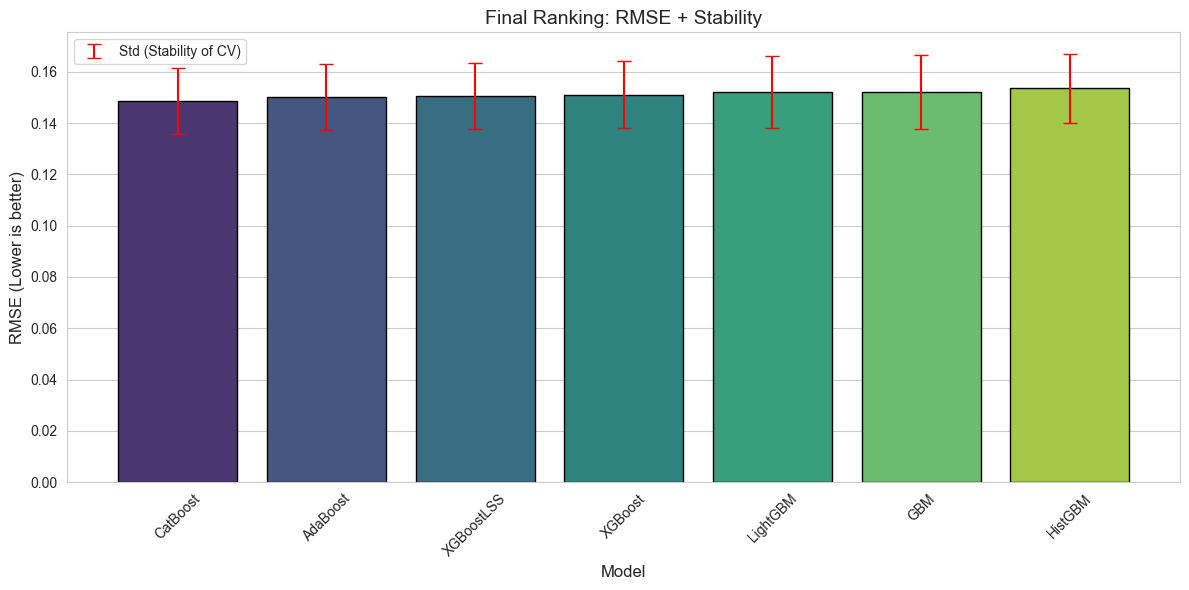


>>> GLOBAL CHAMPION: CatBoost <<<
   RMSE: 0.1485
   MAE:  0.0838
   Stability: +/- 0.0129
   Winning Parameters: {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 100, 'depth': 4}


In [6]:
def find_local_champions(X, y):
    
    tscv = TimeSeriesSplit(n_splits=5)
    
    param_grids = {}
    
    # 1. AdaBoost
    param_grids['AdaBoost'] = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0],
        'loss': ['linear', 'square']
    }
    
    # 2. GBM  
    param_grids['GBM'] = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 4],
        'subsample': [0.8, 1.0]
    }
    
    # 3. HistGBM 
    param_grids['HistGBM'] = {
        'max_iter': [100, 200],
        'learning_rate': [0.05, 0.1],
        'l2_regularization': [0.0, 1.0],
        'max_leaf_nodes': [31, 50]
    }
    
    # 4. XGBoost
    
    param_grids['XGBoost'] = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    
    # 5. LightGBM 
    
    param_grids['LightGBM'] = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1],
        'num_leaves': [20, 31],
        'subsample': [0.8, 1.0]
    }

    # 6. CatBoost
    
    param_grids['CatBoost'] = {
        'iterations': [100, 300],
        'learning_rate': [0.05, 0.1],
        'depth': [4, 6],
        'l2_leaf_reg': [3, 5]
    }
        
    # 7. XGBoostLSS
    param_grids['XGBoostLSS'] = {
        'num_boost_round': [100, 200],
        'eta': [0.05, 0.1],
        'max_depth': [3, 5]
    }
        
    results = []
        
    # Model Initialization
    models = {
        'AdaBoost': AdaBoostRegressor(random_state=42),
        'GBM': GradientBoostingRegressor(random_state=42),
        'HistGBM': HistGradientBoostingRegressor(random_state=42),
    }
    models['XGBoost'] = XGBRegressor(n_jobs=1, verbosity=0, random_state=42)
    models['LightGBM'] = LGBMRegressor(n_jobs=1, verbose=-1, random_state=42)
    models['CatBoost'] = CatBoostRegressor(verbose=0, allow_writing_files=False, random_state=42)
    models['XGBoostLSS'] = SklearnXGBoostLSS()

    print("STARTING OPTIMIZATION (RandomizedSearchCV)")

    for name, model in models.items():
        if name not in param_grids: continue
        
        print(f"\nOptimizing Model: {name} ")
        print(f"   Testing random hyperparameter combinations")
                
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grids[name],
            n_iter=5,            
            scoring={'RMSE': 'neg_root_mean_squared_error', 'MAE': 'neg_mean_absolute_error'},
            refit='RMSE',
            cv=tscv,
            n_jobs=-1,
            random_state=42,
            verbose=0
        )
        
        try:
            search.fit(X, y)
            
            best_idx = search.best_index_
            best_rmse = -search.cv_results_['mean_test_RMSE'][best_idx]
            std_rmse = search.cv_results_['std_test_RMSE'][best_idx]
            best_mae = -search.cv_results_['mean_test_MAE'][best_idx]
            std_mae = search.cv_results_['std_test_MAE'][best_idx]
            best_params = search.best_params_
            
            print(f"   [Local Champion Selected for {name}]")
            print(f"   -> Best Params: {best_params}")
            print(f"   -> Best RMSE:   {best_rmse:.4f}")
            print(f"   -> Best MAE:    {best_mae:.4f}")
            
            results.append({
                'Algorithm_Class': name,
                'Best_Validation_RMSE': best_rmse,
                'RMSE_Std_Dev': std_rmse,
                'Best_Validation_MAE': best_mae,
                'MAE_Std_Dev': std_mae,
                'Best_Params': str(best_params)
            })
            
        except Exception as e:
            print(f"  Error optimizing {name}: {e}")

    # Analysis and Reporting
    print("\n\n FINAL SUMMARY AND RANKING")
    print("(Comparing the best version of each model against each other)")
    
    if results:
        champions_df = pd.DataFrame(results).sort_values(by='Best_Validation_RMSE', ascending=True).reset_index(drop=True)
        
        # Computing difference to leader in %
        best_score = champions_df.loc[0, 'Best_Validation_RMSE']
        champions_df['Diff_to_Leader_%'] = ((champions_df['Best_Validation_RMSE'] - best_score) / best_score) * 100
        
        # Printing table
        print(champions_df[['Algorithm_Class', 'Best_Validation_RMSE', 'Best_Validation_MAE', 'RMSE_Std_Dev', 'Diff_to_Leader_%']].to_string(index=False))
        
        # Saving results
        output_file = os.path.join(DATA_DIR, 'local_champions_rmse_detailed.csv')
        champions_df.to_csv(output_file, index=False)
        
        # Visualization
        plt.figure(figsize=(12, 6))
        sns.set_style("whitegrid")
        
        ax = sns.barplot(
            x='Algorithm_Class', 
            y='Best_Validation_RMSE', 
            data=champions_df, 
            palette='viridis',
            edgecolor='black'
        )
        
        plt.errorbar(
            x=range(len(champions_df)), 
            y=champions_df['Best_Validation_RMSE'], 
            yerr=champions_df['RMSE_Std_Dev'], 
            fmt='none', 
            c='red', 
            capsize=5, 
            label='Std (Stability of CV)'
        )
        
        plt.title('Final Ranking: RMSE + Stability', fontsize=14)
        plt.ylabel('RMSE (Lower is better)', fontsize=12)
        plt.xlabel('Model', fontsize=12)
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # FINAL CONCLUSIONS
        winner = champions_df.iloc[0]
        
        print(f"\n>>> GLOBAL CHAMPION: {winner['Algorithm_Class']} <<<")
        print(f"   RMSE: {winner['Best_Validation_RMSE']:.4f}")
        print(f"   MAE:  {winner['Best_Validation_MAE']:.4f}")
        print(f"   Stability: +/- {winner['RMSE_Std_Dev']:.4f}")
        print(f"   Winning Parameters: {winner['Best_Params']}")

if __name__ == "__main__":
    X, y = load_and_prep_data()
    best_n, best_method = run_feature_selection(X, y, RANKING_PATH)
        
    if best_method == 'Ranking_File':
        top_features = get_top_features_from_ranking(RANKING_PATH, best_n)
    else:
        top_features = get_top_features_from_model(X, y, best_n)
        

    final_features = [f for f in top_features if f in X.columns]
    X_selected = X[final_features]
    find_local_champions(X_selected, y)

#  Updated Model Comparison Summary

##  Best Hyperparameters and Partial Results

| Model | Best Parameters | RMSE |
|------|------------------|------|
| **AdaBoost** | `{'n_estimators': 100, 'loss': 'linear', 'learning_rate': 0.01}` | **0.1501** |
| **GBM** | `{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}` | **0.1522** |
| **HistGBM** | `{'max_leaf_nodes': 31, 'max_iter': 100, 'learning_rate': 0.05, 'l2_regularization': 0.0}` | **0.1536** |
| **XGBoost** | `{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}` | **0.1511** |
| **LightGBM** | `{'subsample': 0.8, 'num_leaves': 20, 'n_estimators': 100, 'learning_rate': 0.05}` | **0.1521** |
| **CatBoost** | `{'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 100, 'depth': 4}` | **0.1485** |
| **XGBoostLSS** | `{'num_boost_round': 100, 'max_depth': 3, 'eta': 0.05}` | **0.1506** |

---

#  Final Ranking (RMSE + Stability)

| Model | Best Validation RMSE | Best Validation MAE | RMSE Std. Dev | Diff to Leader |
|------|-----------------------|---------------------|----------------|----------------|
| **CatBoost** | **0.14851** | 0.08377 | 0.01291 | **0.00%** |
| **AdaBoost** | 0.15008 | 0.08758 | 0.01282 | 1.06% |
| **XGBoostLSS** | 0.15060 | 0.08334 | 0.01282 | 1.41% |
| **XGBoost** | 0.15108 | 0.08400 | 0.01317 | 1.73% |
| **LightGBM** | 0.15215 | 0.08707 | 0.01405 | 2.45% |
| **GBM** | 0.15215 | 0.08505 | 0.01442 | 2.45% |
| **HistGBM** | 0.15359 | 0.08823 | 0.01343 | 3.42% |

---

#  Interpretation of the RMSE Chart

The bar chart visualizes the performance of all optimized models:

- Each bar represents the **best optimized version** of a model.
- The **height** corresponds to mean RMSE.
- **Red error bars** show the standard deviation of RMSE from cross-validation (model stability).

### Key Points:
- **CatBoost** is the strongest model with the lowest RMSE and excellent stability.
- AdaBoost, XGBoostLSS, and XGBoost follow very closely behind.
- LightGBM and GBM perform similarly, slightly weaker than the leaders.
- **HistGBM** has the highest RMSE and the least stability among tested models.

---

## Global Champion: CatBoost

**Best RMSE:** **0.1485**

**Winning Hyperparameters:**
```python
{
    'learning_rate': 0.05,
    'l2_leaf_reg': 3,
    'iterations': 100,
    'depth': 4
}


##  Best Hyperparameters and Partial Results

| Model | Best Parameters | RMSE |
|------|------------------|------|
| **AdaBoost** | `{'n_estimators': 100, 'loss': 'linear', 'learning_rate': 0.01}` | **0.1501** |
| **GBM** | `{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}` | **0.1522** |
| **HistGBM** | `{'max_leaf_nodes': 31, 'max_iter': 100, 'learning_rate': 0.05, 'l2_regularization': 0.0}` | **0.1536** |
| **XGBoost** | `{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}` | **0.1511** |
| **LightGBM** | `{'subsample': 0.8, 'num_leaves': 20, 'n_estimators': 100, 'learning_rate': 0.05}` | **0.1521** |
| **CatBoost** | `{'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 100, 'depth': 4}` | **0.1485** |
| **XGBoostLSS** | `{'num_boost_round': 100, 'max_depth': 3, 'eta': 0.05}` | **0.1506** |

---

##  Final Ranking (RMSE + Stability)

| Model | Best Validation RMSE | Best Validation MAE | RMSE Std. Dev | Diff to Leader |
|------|-----------------------|---------------------|----------------|----------------|
| **CatBoost** | **0.14851** | 0.08377 | 0.01291 | **0.00%** |
| **AdaBoost** | 0.15008 | 0.08758 | 0.01282 | 1.06% |
| **XGBoostLSS** | 0.15060 | 0.08334 | 0.01282 | 1.41% |
| **XGBoost** | 0.15108 | 0.08400 | 0.01317 | 1.73% |
| **LightGBM** | 0.15215 | 0.08707 | 0.01405 | 2.45% |
| **GBM** | 0.15215 | 0.08505 | 0.01442 | 2.45% |
| **HistGBM** | 0.15359 | 0.08823 | 0.01343 | 3.42% |

---

## The bar chart displays the RMSE performance of all optimized models, with lower values indicating better predictive accuracy.

What the plot shows:
- Each bar represents the best version of a model after hyperparameter tuning.
- The height of each bar corresponds to the model’s mean RMSE.
- The red error bars represent the standard deviation from cross-validation, providing insight into each model's stability and consistency.

Interpretation:
- **CatBoost** has the lowest bar, confirming it delivered the best RMSE among all models.
- CatBoost’s error bar is relatively short, indicating strong stability across folds.
- Other top models (AdaBoost, XGBoost, XGBoostLSS, LightGBM) have RMSE values very close to each other, with overlapping error bars — showing no major statistical dominance besides CatBoost.
- **HistGBM** shows the highest RMSE and one of the wider error bars, meaning it was both less accurate and less stable.
- In summary, the plot illustrates that while most models perform similarly, CatBoost consistently outperforms the rest in both accuracy and reliability.

---

#  Global Champion: CatBoost
**Best RMSE:** **0.1485**

**Winning Hyperparameters:**
```python
{
    'learning_rate': 0.05,
    'l2_leaf_reg': 3,
    'iterations': 100,
    'depth': 4
}

In [7]:
def save_best_models(X, y):
    
    results_path = os.path.join(DATA_DIR, 'local_champions_rmse_detailed.csv')
    
    if not os.path.exists(results_path):
        print(f"No file: {results_path}")
        return
        
    champions_df = pd.read_csv(results_path)
    
    if not os.path.exists(MODELS_DIR):
        os.makedirs(MODELS_DIR)
        
    print(f"Lokalization: {MODELS_DIR}\n")
    
    for index, row in champions_df.iterrows():
        model_name = row['Algorithm_Class']
        params_str = row['Best_Params']
        
        rmse_score = row.get('Best_Validation_RMSE', 'N/A')
        mae_score = row.get('Best_Validation_MAE', 'N/A')
        
        try:
            params = ast.literal_eval(params_str)
        except Exception as e:
            print(f" Error parsing params for {model_name}: {e}")
            continue
                    
        model = None
        
        try:
            if model_name == 'AdaBoost':
                model = AdaBoostRegressor(**params, random_state=42)
            
            elif model_name == 'GBM':
                model = GradientBoostingRegressor(**params, random_state=42)
                
            elif model_name == 'HistGBM':
                model = HistGradientBoostingRegressor(**params, random_state=42)
                
            elif model_name == 'XGBoost' and 'XGBRegressor' in globals():
                model = XGBRegressor(**params, n_jobs=-1, verbosity=0, random_state=42)
                
            elif model_name == 'LightGBM' and 'LGBMRegressor' in globals():
                model = LGBMRegressor(**params, n_jobs=-1, verbose=-1, random_state=42)
                
            elif model_name == 'CatBoost' and 'CatBoostRegressor' in globals():
                model = CatBoostRegressor(**params, verbose=0, allow_writing_files=False, random_state=42)
                
            elif model_name == 'XGBoostLSS' and 'SklearnXGBoostLSS' in globals():
                model = SklearnXGBoostLSS(**params)
            
            if model is not None:
                model.fit(X, y)
                
                model_filename = os.path.join(MODELS_DIR, f"{model_name.lower()}_best.pkl")
                with open(model_filename, 'wb') as f:
                    pickle.dump(model, f)
                
                scores_data = {
                    'Model': model_name,
                    'RMSE': rmse_score,
                    'MAE': mae_score,
                    'Best_Params': params
                }
                
                scores_filename = os.path.join(MODELS_DIR, f"{model_name.lower()}_scores.sav")
                with open(scores_filename, 'wb') as f:
                    pickle.dump(scores_data, f)

                
            else:
                print(f" Model {model_name} is not available in the environment.")
                
        except Exception as e:
            print(f"    Error processing {model_name}: {e}")


if 'X' in globals() and 'y' in globals():
    save_best_models(X, y)
else:
    print("First load (X, y)")

Lokalization: ../models

